# **IMPORT LIBRARIES**

In [1]:
import gzip
import shutil
from pathlib import Path
from urllib.parse import urljoin
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from datetime import timedelta
from time import time
import struct
import collections
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# **DOWNLOAD AND EXTRACT THE ZIP FILE CONTAINING THE NASDAQ MARKET DATA**




In [2]:
!wget 'https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/01302019.NASDAQ_ITCH50.gz'

with gzip.open('01302019.NASDAQ_ITCH50.gz', 'rb') as f_in:
  with open('01302019.NASDAQ_ITCH50.bin', 'wb') as f_out:
    shutil.copyfileobj(f_in, f_out)

--2023-12-25 12:48:45--  https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/01302019.NASDAQ_ITCH50.gz
Resolving emi.nasdaq.com (emi.nasdaq.com)... 198.55.199.19
Connecting to emi.nasdaq.com (emi.nasdaq.com)|198.55.199.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4764426091 (4.4G) [application/x-gzip]
Saving to: ‘01302019.NASDAQ_ITCH50.gz’

01302019.NASDAQ_ITC 100%[===================>]   4.44G  82.6MB/s    in 59s     

2023-12-25 12:49:44 (77.4 MB/s) - ‘01302019.NASDAQ_ITCH50.gz’ saved [4764426091/4764426091]



In [3]:
itch_store = str('itch.h5')
date = '01302019'
file_name = Path('/content/'+ date +'.NASDAQ_ITCH50.bin')

# **DEFINE ENCODING, EVENT CODES AND FORMAT DICTIONARIES**




In [4]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

In [5]:
event_codes = {'O': 'START OF MESSAGES',
               'S': 'START OF SYSTEM HOURS',
               'Q': 'START OF MARKET HOURS',
               'M': 'END OF MARKET HOURS',
               'E': 'END OF SYSTEM HOURS',
               'C': 'END OF MESSAGES'}

In [6]:
formats = {
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('integer', 2): 'H',
    ('integer', 4): 'I',
    ('integer', 6): '6s',
    ('integer', 8): 'Q',
}

# **READING NASDAQ FORMAT SPECIFICATIONS FILE COVERTED TO XLSX FORMAT**




First the given document (https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHspecification.pdf) is parsed to obtain a dataframe which contains information of all the message formats in tabular format.

In [8]:
message_data = (pd.read_excel('message_types.xlsx',
                              sheet_name='messages').sort_values('id').drop('id', axis=1))

# **CLEANING AND MODIFYING THE READ FORMATS FROM NASDAQ FILE**




In [9]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = (df.value.str.strip())
    df.notes = df.notes.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('/', '_')
               .str.replace('-', '_'))
    mask = df['name'] == 'message_type'
    df.loc[mask, 'message_type'] = df.loc[mask, 'value']

    df['message_type'] = df['message_type'].ffill()
    df.value = (df.value.str.lower()
                       .str.replace(')', '')
                       .str.replace(' ', '_')
                       .str.replace('(', ''))
    df = df[df['name']!='message_type']
    # Zip 'value' and 'length' columns together and convert to a list of tuples
    value_length_pairs = list(zip(df['value'], df['length']))

    # Map each ('value', 'length') tuple to its corresponding format using a list comprehension
    # This assumes that every ('value', 'length') tuple has an entry in the formats dictionary
    df['formats'] = [formats[pair] for pair in value_length_pairs]
    return df
message_types = clean_message_types(message_data)

<ipython-input-9-c4944771f8ed>:18: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace('(', '')
<ipython-input-9-c4944771f8ed>:19: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .str.replace(')', ''))
<ipython-input-9-c4944771f8ed>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['formats'] = [formats[pair] for pair in value_length_pairs]


In [10]:
message_types

,name,offset,length,value,notes,message_type,formats
1,stock_locate,1,2,integer,Always 0,S,H
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S,H
3,timestamp,5,6,integer,Nanoseconds since midnight,S,6s
4,event_code,11,1,alpha,See System Event Codes below,S,s
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R,H
...,...,...,...,...,...,...,...
168,far_price,36,4,price_4,A hypothetical auction-clearing price for cros...,I,I
169,near_price,40,4,price_4,A hypothetical auction-clearing price for cros...,I,I
170,current_reference_price,44,4,price_4,The price at which the NOII shares are being c...,I,I
171,cross_type,48,1,alpha,The type of Nasdaq cross for which the NOII me...,I,s


# **GENERATING MESSAGE FORMAT AND MESSAGE LENGTH FOR EACH MESSAGE TYPE**




In [11]:
alpha_msgs =  message_types[message_types.value == 'alpha'].set_index('name').groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

message_fields, format_string = {}, {}
for t, message in message_types.groupby('message_type'):
    field_names = message.name.tolist()
    field_formats = message.formats.tolist()
    message_fields[t] = namedtuple(typename=t, field_names=field_names)
    format_string[t] = '!' + ''.join(field_formats)

# **DEFINING SOME UTILITY FUNCTIONS FOR STORING THE READ DATA FROM NASDAQ MARKET MESSAGES**




In [12]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for m_type, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if m_type in alpha_formats.keys():
              for col in alpha_formats[m_type].keys():
                  if m_type != 'R' and col == 'stock':
                    data = data.drop(col, axis=1)
                    continue
                  data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
                  if col in encoding.keys():
                      data.loc[:, col] = data.loc[:, col].map(encoding[col])

            ## getting alpha lengths
            sz = alpha_length.get(m_type)
            if m_type in  alpha_length.keys():
                sz = {c: sz.get(c) for c in data.columns}
            columns = ['stock_locate']
            if m_type == 'R':
                columns.append('stock')

            ## storing information
            store.append(m_type,
                         data,
                         format='t',
                         min_itemsize=sz,
                         data_columns=columns)

def get_bytedata(data):
  return int.from_bytes(data, byteorder='big', signed=False)

def format_time(t):
    """Return a formatted time string of the form 'HH:MM:SS'
    based on a numeric time() value"""
    # Create a timedelta object based on the number of seconds.
    time_delta = timedelta(seconds=t)
    time_formatted = (datetime.min + time_delta).time().strftime("%H:%M:%S.%f")[:-3]
    return time_formatted

# **BINARY DATA Parser Code**

In [14]:
msg_cnt = 0
message_type_counter = Counter()
messages = collections.defaultdict(list)

start = time()
with file_name.open('rb') as data:
    while True:
        ## MSG_FORMAT = [MSG_SZ, MSG_TYPE of size 1 byte, MSG_RECORD of size MSG_SZ-1 byte]
        # get message type by reading one byte
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

        # get message type by reading one byte
        message_type = data.read(1).decode('ascii')
        message_type_counter.update([message_type])

        # read & store message
        try:
            message = message_fields[message_type]._make(unpack(format_string[message_type], data.read(message_size-1)))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)


        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes((message.timestamp) , byteorder='big')*1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{msg_cnt:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        msg_cnt += 1

        if msg_cnt % 2.5e7 == 0:
            res = store_messages(messages)
            elapsed_time = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{msg_cnt:12,.0f}\t{elapsed_time}')
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Messages parsed......\nTotal Duration:', format_time(time() - start))


 START OF MESSAGES
	03:03:59.687	           0

 START OF SYSTEM HOURS
	04:00:00.000	     219,799

 START OF MARKET HOURS
	09:30:00.000	  10,532,163
	09:30:00.000	  25,000,000	00:04:52.011
	09:30:00.000	  50,000,000	00:09:21.879
	09:30:00.000	  75,000,000	00:14:37.969
	09:30:00.000	 100,000,000	00:20:08.631


/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/index``
  warnings.warn("a closed node found in the registry: "


	09:30:00.000	 125,000,000	00:25:00.001
	09:30:00.000	 150,000,000	00:29:59.002


/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/sorted``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/indices``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/sortedLR``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/indicesLR``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python

	09:30:00.000	 175,000,000	00:34:30.147


/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/index``
  warnings.warn("a closed node found in the registry: "


	09:30:00.000	 200,000,000	00:39:13.159
	09:30:00.000	 225,000,000	00:43:46.987


/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/sorted``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/indices``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/sortedLR``
  warnings.warn("a closed node found in the registry: "
/usr/local/lib/python3.10/dist-packages/tables/file.py:411: UserWarning: a closed node found in the registry: ``/A/_i_table/shares/indicesLR``
  warnings.warn("a closed node found in the registry: "


	09:30:00.000	 250,000,000	00:48:28.317
	09:30:00.000	 275,000,000	00:53:13.084
	09:30:00.000	 300,000,000	00:57:58.573
	09:30:00.000	 325,000,000	01:02:34.510
	09:30:00.000	 350,000,000	01:07:15.122

 END OF MARKET HOURS
	16:00:00.000	 365,323,584

 END OF SYSTEM HOURS
	20:00:00.000	 368,335,086

 END OF MESSAGES
	20:05:00.000	 368,366,633
Messages parsed......
Total Duration: 01:10:50.968


#**ANALYSING THE STORED DATA**

At the startof each trading day,Nasdaq disseminates stock directory messages for allactive symbols in the Nasdaq
execution system.
Market data redistributors should process this message to populate the Financial Status Indicator(required display
field) and the Market Category (recommended display field) for Nasdaq listed issues.

In [15]:
import pandas as pd

# Sample DataFrame
data = {
    'message_type': ['S', 'R', 'H', 'Y', 'L', 'V', 'W', 'K', 'J', 'h', 'A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q', 'B', 'I'],
    'name': [
        'system_event',
        'stock_directory',
        'stock_trading_action',
        'reg_sho_short_sale_price_test_restricted_indicator',
        'market_participant_position',
        'market_wide_circuit_breaker_decline_level',
        'market-wide_circuit_breaker_status',
        'ipo_quoting_period_update',
        'luld_auction_collar',
        'operational_halt',
        'add_order_no_mpid_attribution',
        'add_order_mpid_attribution',
        'order_executed',
        'order_executed_with_price',
        'order_cancel',
        'order_delete',
        'order_replace',
        'trade',
        'cross_trade',
        'broken_trade',
        'noii'
    ]
}

df = pd.DataFrame(data)
# Convert DataFrame to dictionary
message_labels_dict = df.set_index('message_type')['name'].to_dict()


import pandas as pd
pd.set_option('display.width', 1000)

# Assuming message_type_counter and message_labels_dict are defined as before

# Step 1: Create DataFrame from message_type_counter
count_df = pd.DataFrame(list(message_type_counter.items()), columns=['Message Type', 'Number of Trades'])

# Step 2: Create DataFrame from message_labels_dict
labels_df = pd.DataFrame(list(message_labels_dict.items()), columns=['Message Type', 'Message Name'])

# Step 3: Merge the DataFrames
merged_df = count_df.merge(labels_df, on='Message Type').sort_values('Number of Trades', ascending=False)

print(merged_df)

   Message Type  Number of Trades                                       Message Name
5             A         162970455                      add_order_no_mpid_attribution
6             D         158273361                                       order_delete
8             U          27222746                                      order_replace
10            E           8096995                                     order_executed
9             X           4669874                                       order_cancel
13            I           3684511                                               noii
7             F           1725898                         add_order_mpid_attribution
11            P           1326184                                              trade
4             L            193769                        market_participant_position
14            C            158886                          order_executed_with_price
15            Q             17430                                

In [16]:
with pd.HDFStore(itch_store) as store:
    print("Stock Directory ...", store['R'])
    print("Cross Trade Messages ...", store['Q'])
    print("Trade Messages ...", store['P'])

Stock Directory ...       stock_locate  tracking_number                 timestamp   stock market_category financial_status_indicator  round_lot_size round_lots_only issue_classification issue_sub_type authenticity short_sale_threshold_indicator ipo_flag luld_reference_price_tier etp_flag  etp_leverage_factor inverse_indicator
0                1                0 0 days 03:08:34.234545561       A               N                                        100               N                    C              Z            P                              N                                  1        N                    0                 N
1                2                0 0 days 03:08:34.236108077      AA               N                                        100               N                    C              Z            P                              N                                  1        N                    1                 N
2                3                0 0 days 03:08:34.2361

# *Percentage Share of Traded Value for Top 50 stocks*

At the end of the day we want only information for the traded stocks and their shares. Hence, we get the traded and the cross-traded stocks for the day and use the stock directory to map these stocks.

<ipython-input-17-19cbd6f245a9>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  trades = store['P'].append(cross_trades, sort=False)


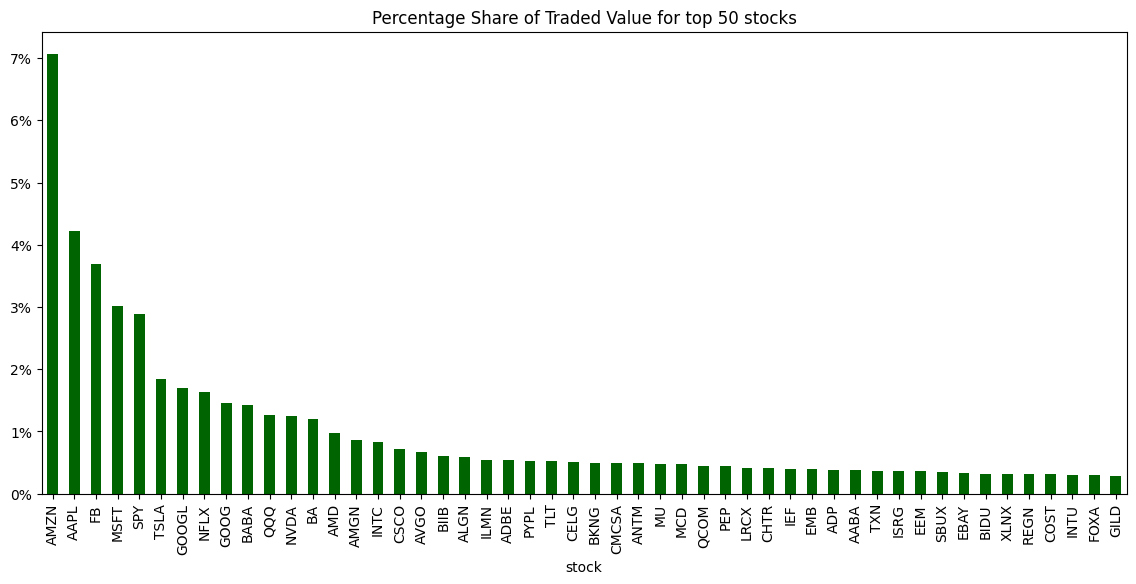

In [17]:
max_num_of_trades =  50
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    cross_trades = store['Q'].rename(columns={'cross_price': 'price'})
    trades = store['P'].append(cross_trades, sort=False)
    trades = trades.merge(stocks)
trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())
trades = trades.sort_values(by=['stock', 'timestamp'])
trades = trades.reset_index(drop=True)
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:max_num_of_trades].plot.bar(figsize=(14, 6), color='darkgreen', title=f'Percentage Share of Traded Value for top {max_num_of_trades} stocks')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

In [18]:
trades

,stock_locate,tracking_number,timestamp,order_reference_number,buy_sell_indicator,shares,price,match_number,cross_type,stock,value,value_share
0,1,1,0 days 09:30:00.901235936,NaN,NaN,0,0,176107,0.0,A,0,0.000000e+00
1,1,2,0 days 09:33:13.153692500,0.0,1.0,100,740200,343805,NaN,A,74020000,4.058845e-07
2,1,4,0 days 09:33:13.153811638,0.0,1.0,61,740100,343810,NaN,A,45146100,2.475561e-07
3,1,2,0 days 09:33:22.077130206,0.0,1.0,200,740100,350818,NaN,A,148020000,8.116594e-07
4,1,2,0 days 09:33:22.077151730,0.0,1.0,300,740100,350819,NaN,A,222030000,1.217489e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
1343618,8713,2,0 days 15:44:19.260016839,0.0,1.0,100,50350,8591887,NaN,ZYNE,5035000,2.760914e-08
1343619,8713,2,0 days 15:57:39.979101064,0.0,1.0,100,50150,9333468,NaN,ZYNE,5015000,2.749947e-08
1343620,8713,1,0 days 16:00:00.537636636,NaN,NaN,46941,50300,9667964,1.0,ZYNE,2361132300,1.294714e-05
1343621,8713,2,0 days 16:21:47.887520133,0.0,1.0,100,52300,9854003,NaN,ZYNE,5230000,2.867841e-08


# *Calculating VWAP for each stock*

For each hour, if there are multiple rows for the stock, we calculate VWAP using = SUM_OVER_HOUR(price_of_per_share_stock*number_of_shares_bought_or_sold)/ total_number_of_shares_bought_or_sold_in_that_hour

In [19]:
# Set 'timestamp' as the index
trades.set_index('timestamp', inplace=True)
# Group by stock symbol and hour, then calculate VWAP
def calculate_vwap(group):
    total_value = group['value'].sum()
    total_shares = group['shares'].sum()
    if total_shares == 0:
        return float('nan')  # Return NaN if no shares were traded
    else:
        return total_value / total_shares

vwap = trades.groupby(['stock', pd.Grouper(freq='H')]).apply(calculate_vwap)
# Reset index to convert back to a regular DataFrame
vwap = vwap.reset_index(name='VWAP')
vwap['VWAP'] = vwap['VWAP'].apply(lambda x: f"{x:.2f}")

In [20]:
top_10_stocks = trade_summary.head(50).index.tolist()
print(top_10_stocks)

['AMZN', 'AAPL', 'FB', 'MSFT', 'SPY', 'TSLA', 'GOOGL', 'NFLX', 'GOOG', 'BABA', 'QQQ', 'NVDA', 'BA', 'AMD', 'AMGN', 'INTC', 'CSCO', 'AVGO', 'BIIB', 'ALGN', 'ILMN', 'ADBE', 'PYPL', 'TLT', 'CELG', 'BKNG', 'CMCSA', 'ANTM', 'MU', 'MCD', 'QCOM', 'PEP', 'LRCX', 'CHTR', 'IEF', 'EMB', 'ADP', 'AABA', 'TXN', 'ISRG', 'EEM', 'SBUX', 'EBAY', 'BIDU', 'XLNX', 'REGN', 'COST', 'INTU', 'FOXA', 'GILD']


In [21]:
vwap[vwap['stock']=='COST']

,stock,timestamp,VWAP
9348,COST,0 days 09:00:00.199973027,2103803.37
9349,COST,0 days 10:00:00.199973027,2098951.49
9350,COST,0 days 11:00:00.199973027,2105475.61
9351,COST,0 days 12:00:00.199973027,2107650.65
9352,COST,0 days 13:00:00.199973027,2100550.24
9353,COST,0 days 14:00:00.199973027,2114012.06
9354,COST,0 days 15:00:00.199973027,2113482.00
9355,COST,0 days 16:00:00.199973027,2113499.91
9356,COST,0 days 18:00:00.199973027,2112000.00


# **VWAP for top 50 stocks (by percentage contribution in the traded value) over each hour**

# **Closing VWAP Price for the top 50 stocks**

In order to get the VWAP for stocks not in top 50, replace `for stock in top_10_stocks:` in the below code block with `for stock in stocks:`



<ipython-input-22-bd52fb0fcd18>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['VWAP'] = df['VWAP'].astype(float)


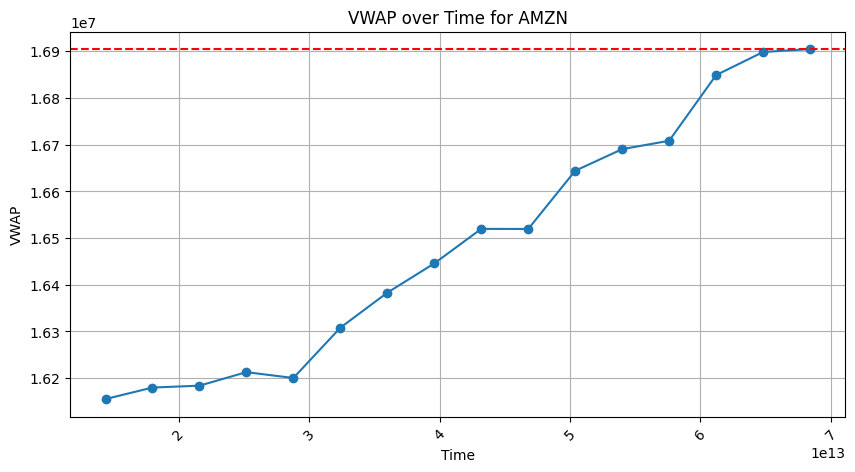

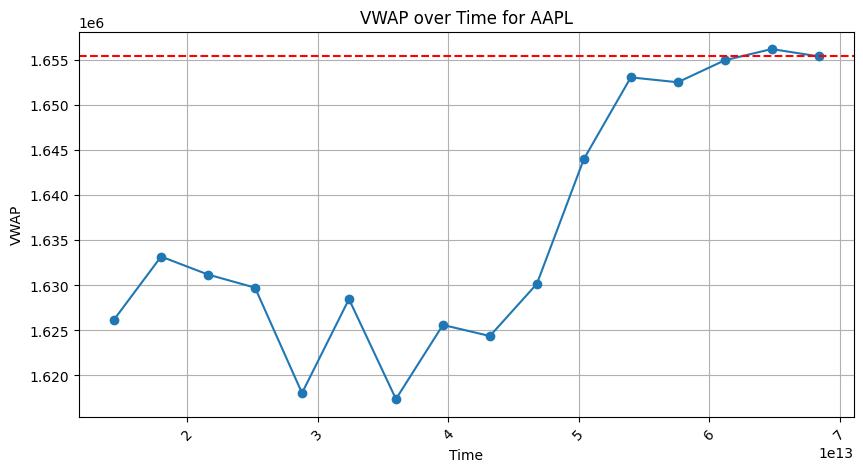

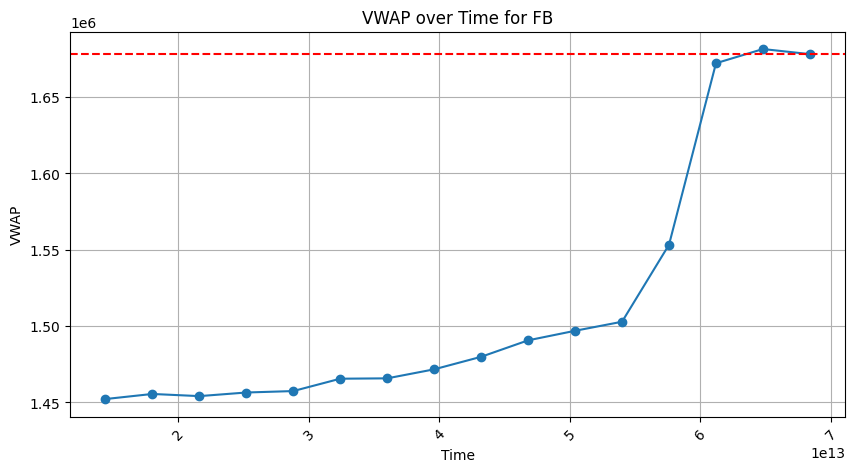

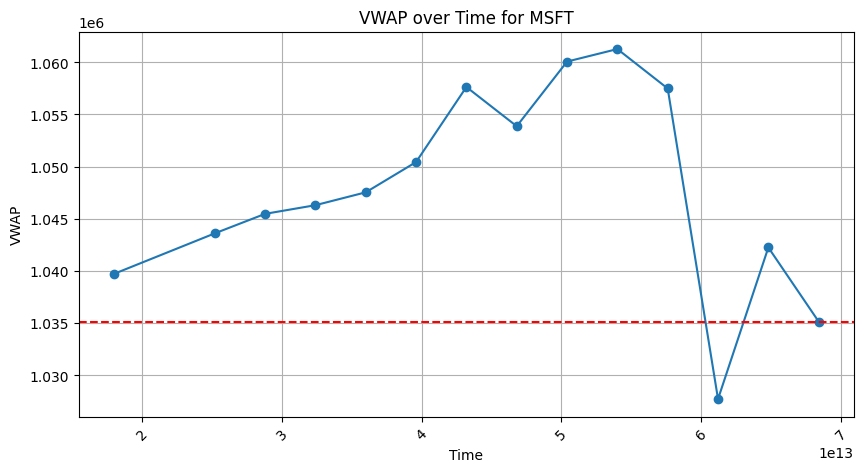

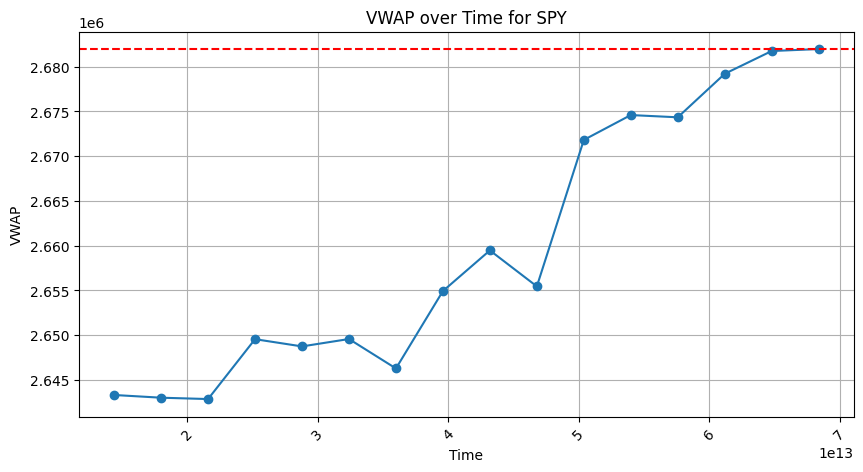

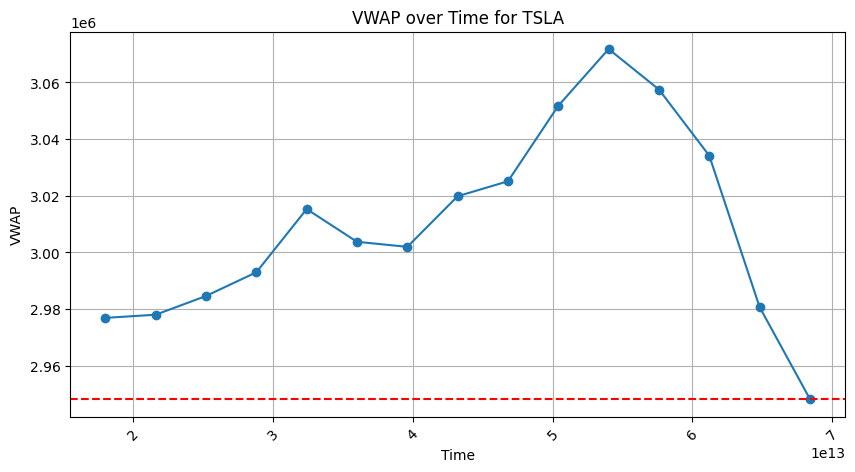

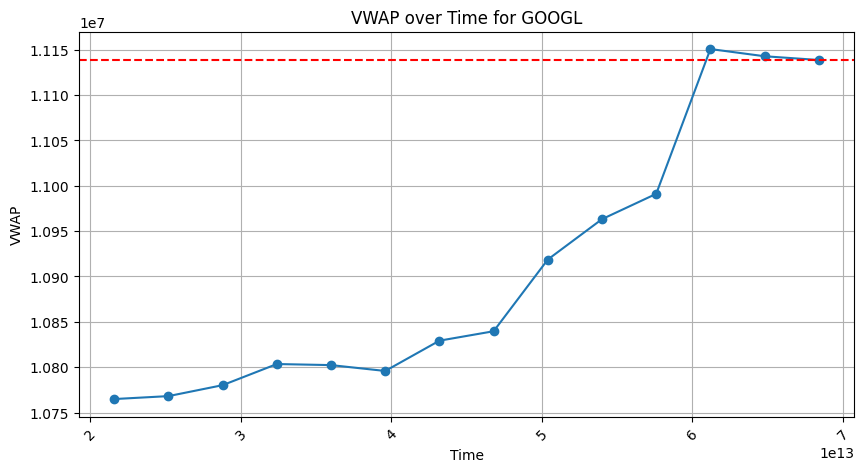

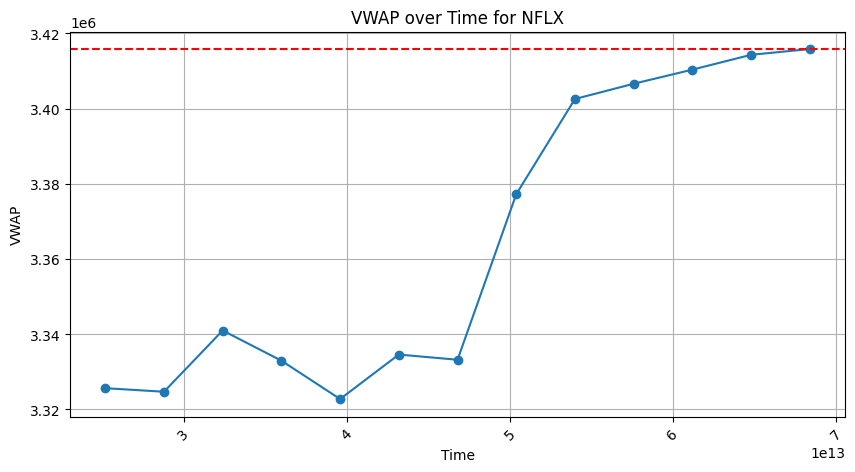

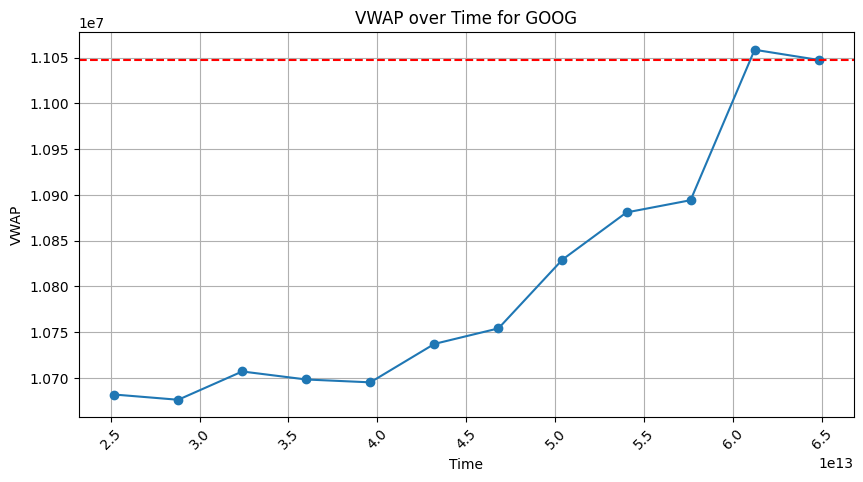

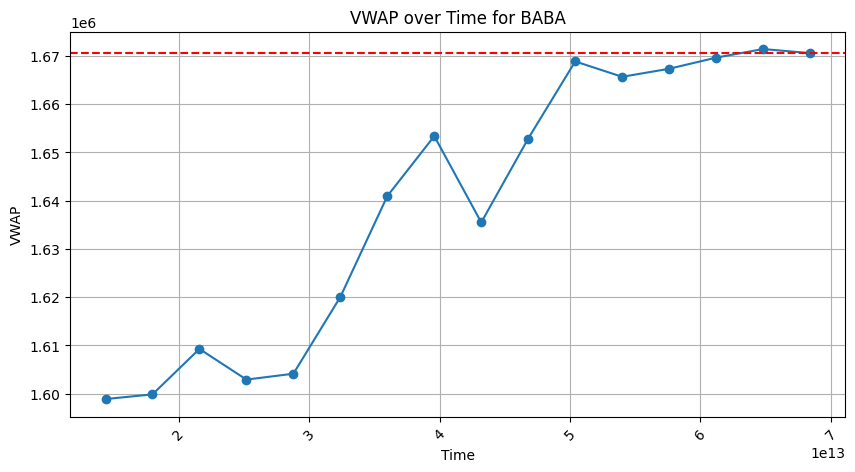

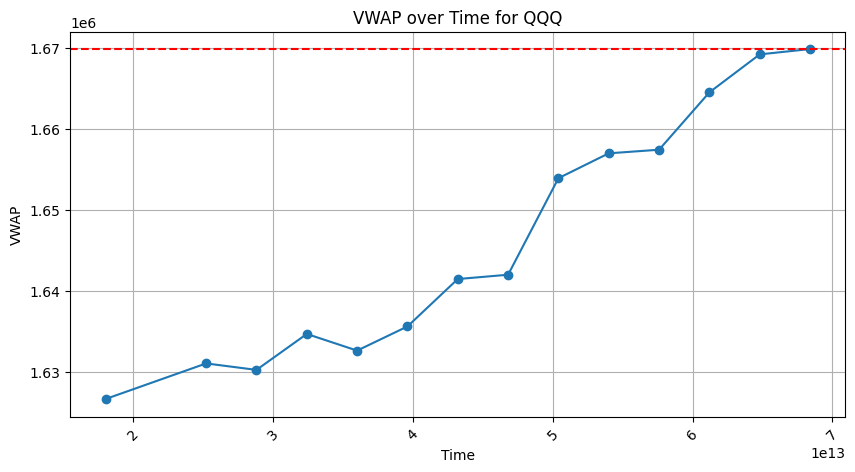

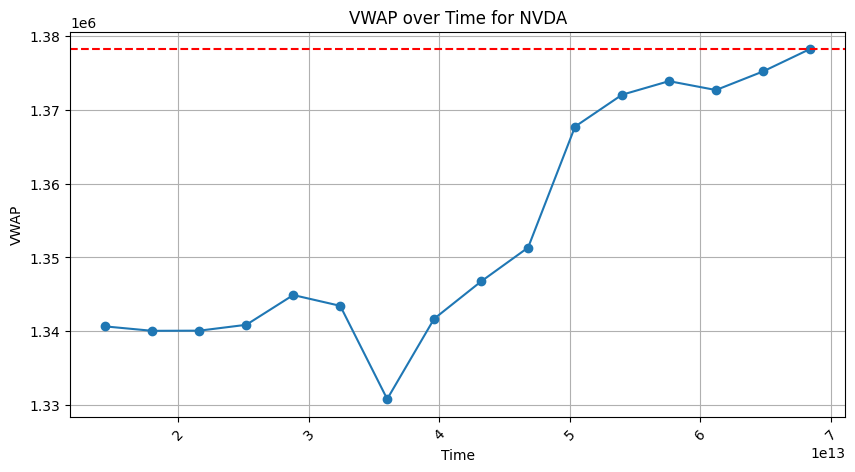

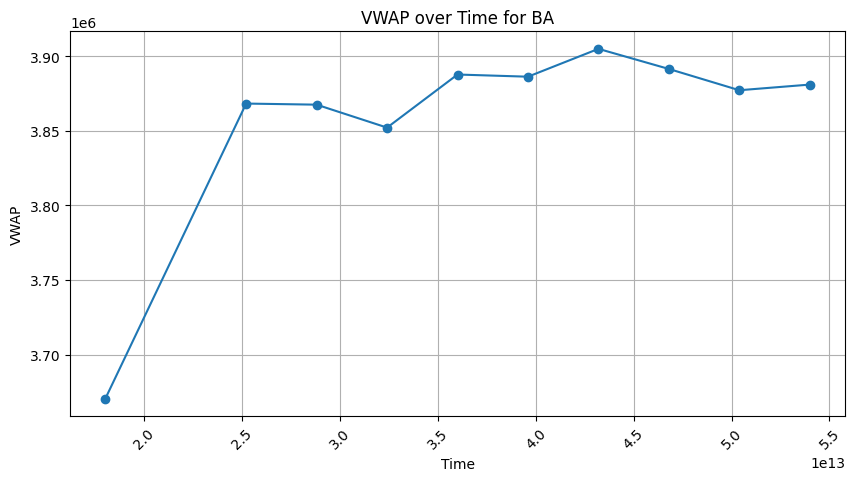

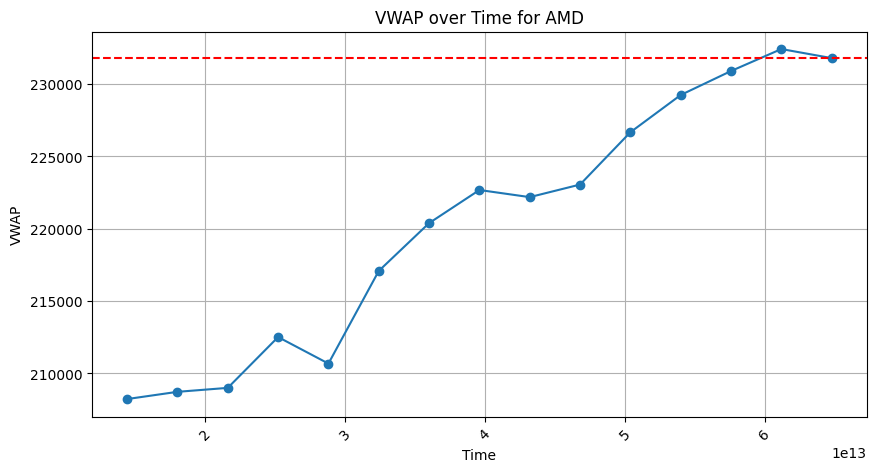

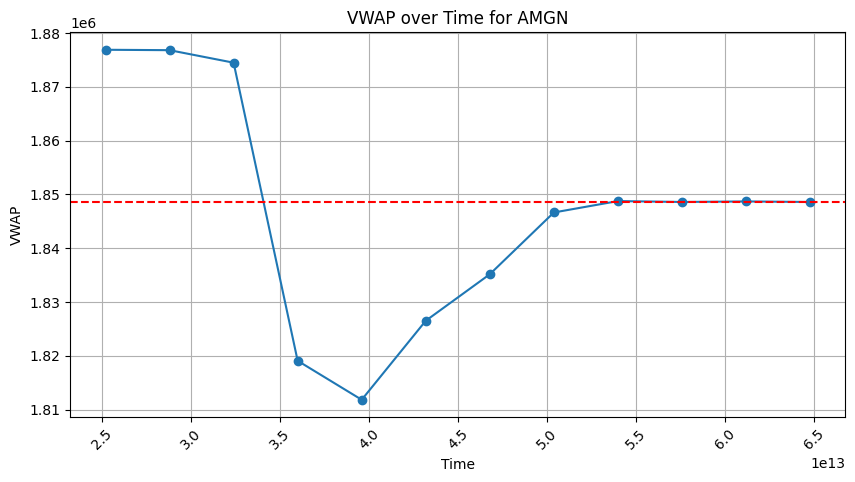

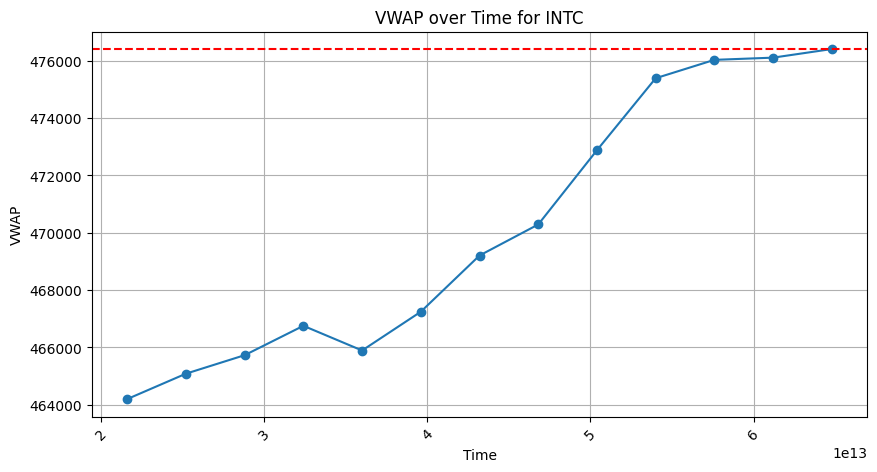

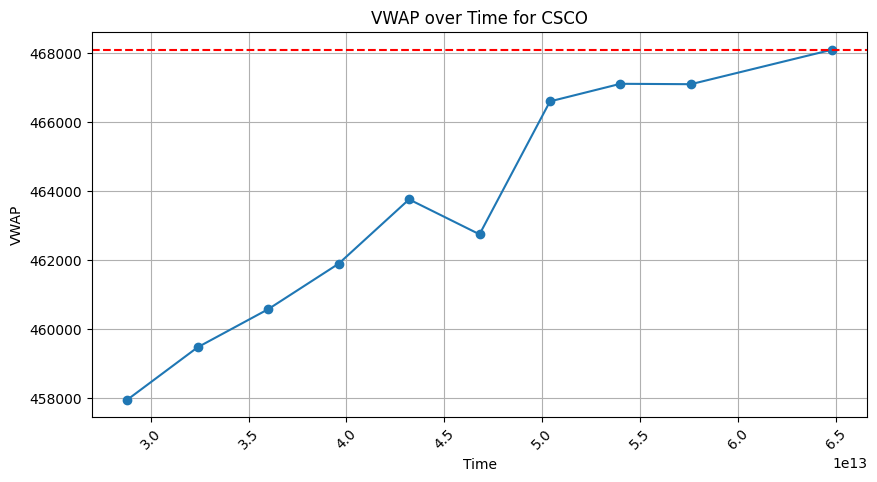

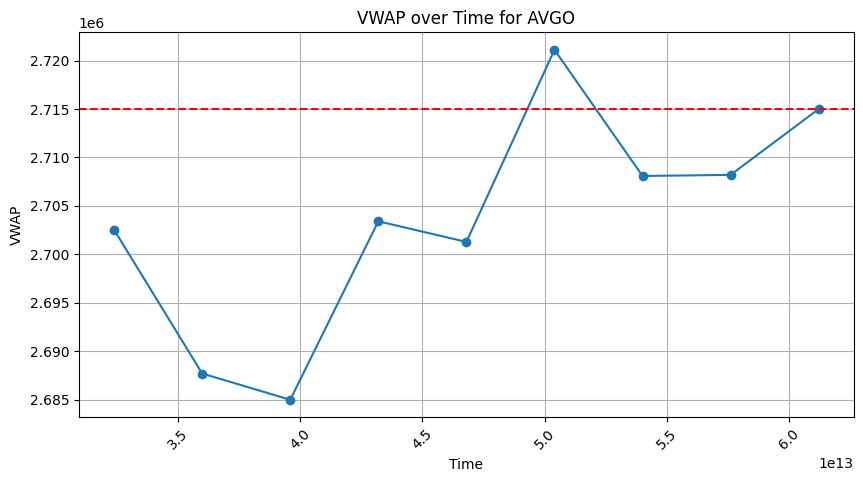

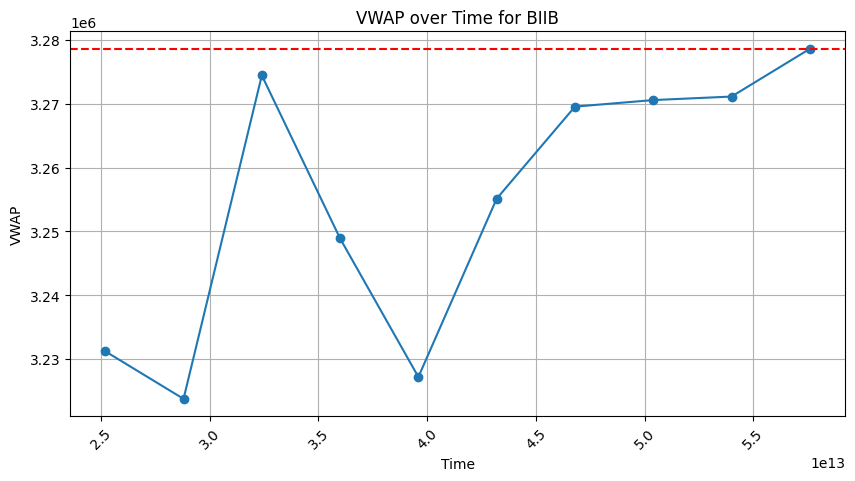

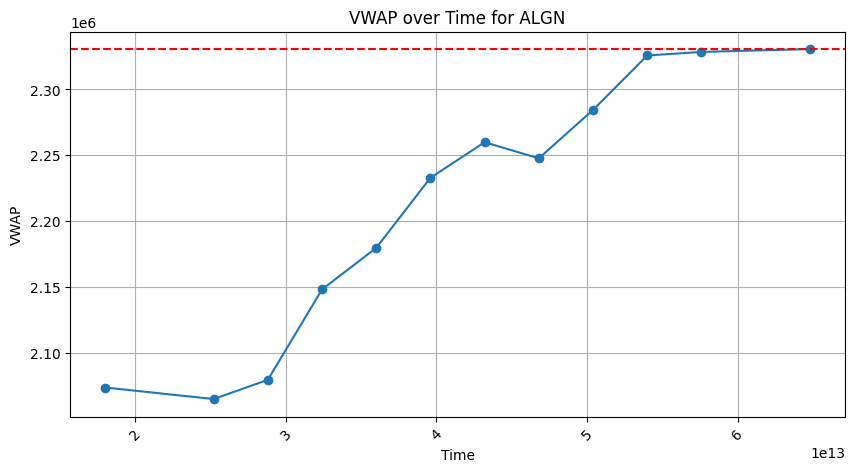

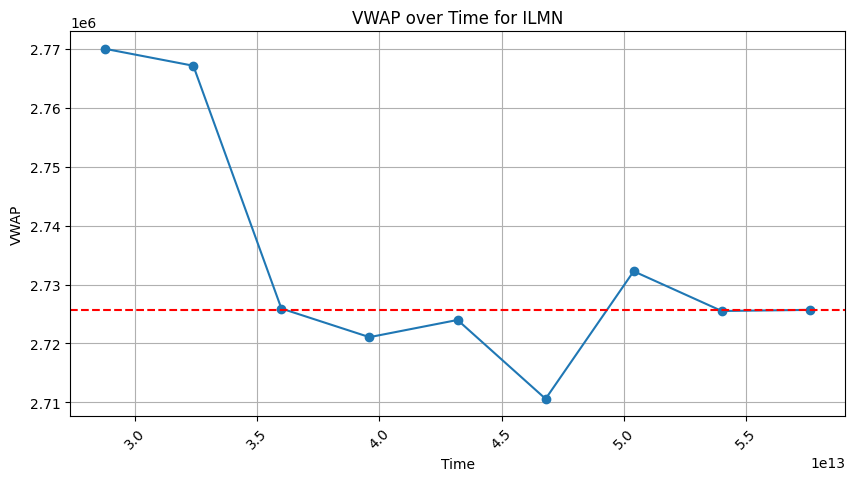

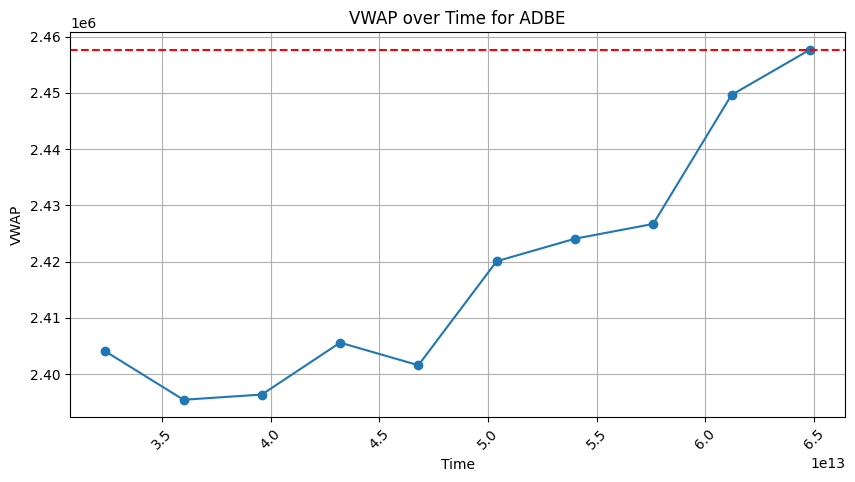

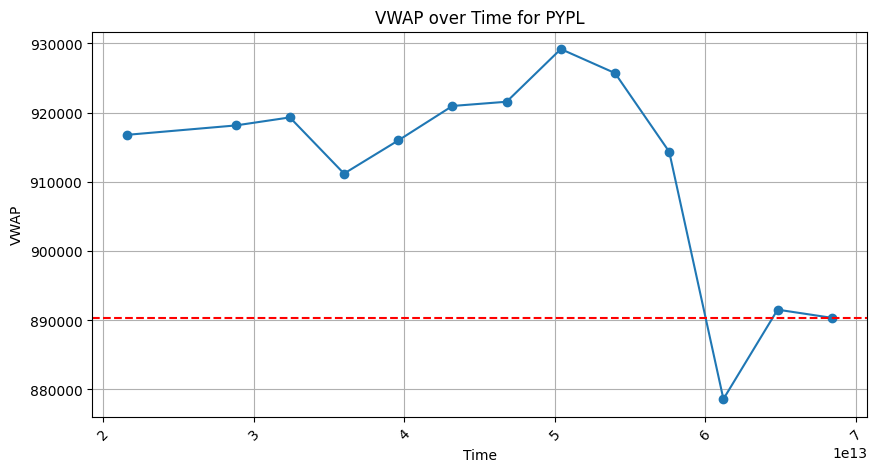

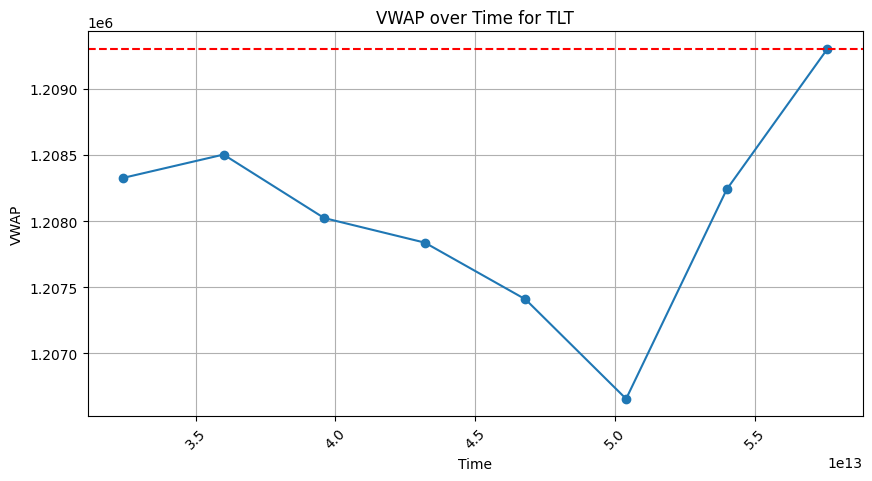

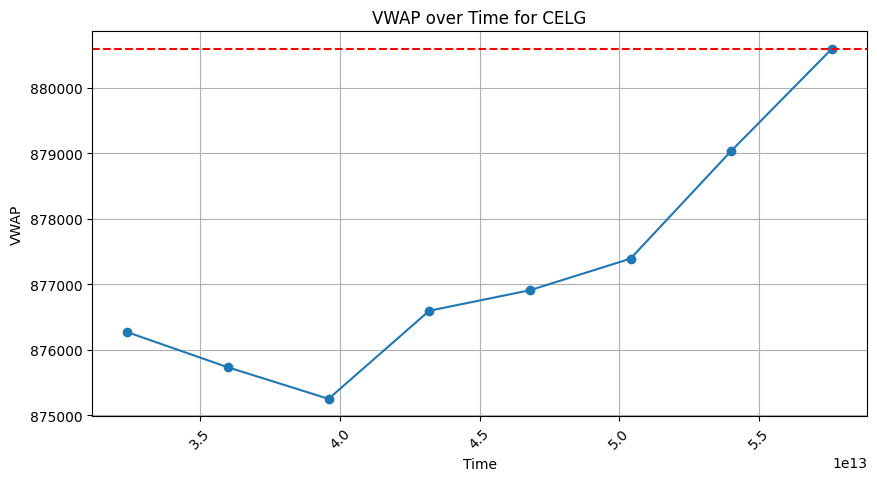

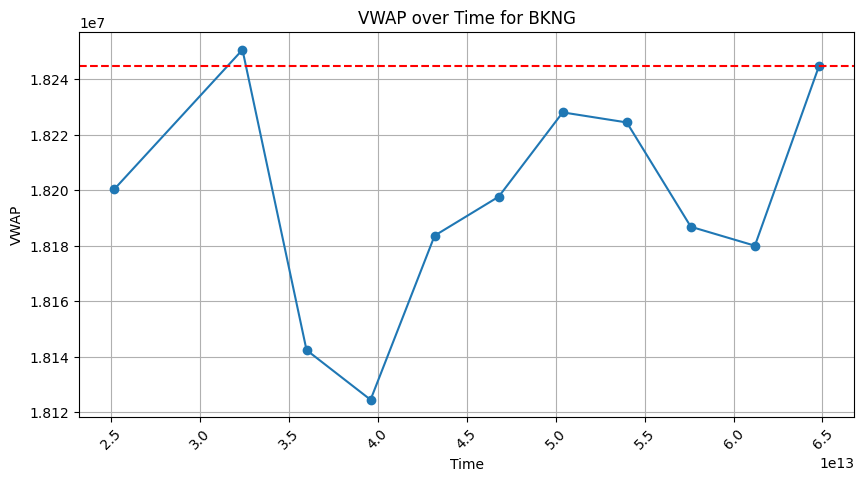

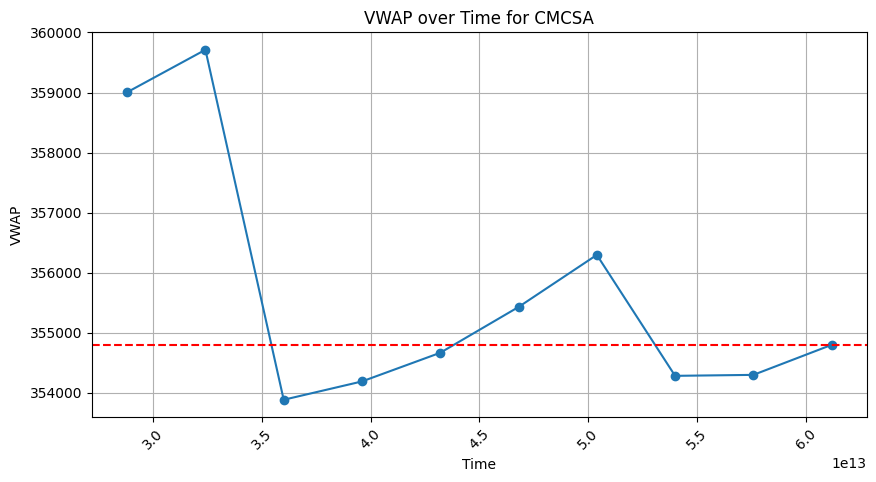

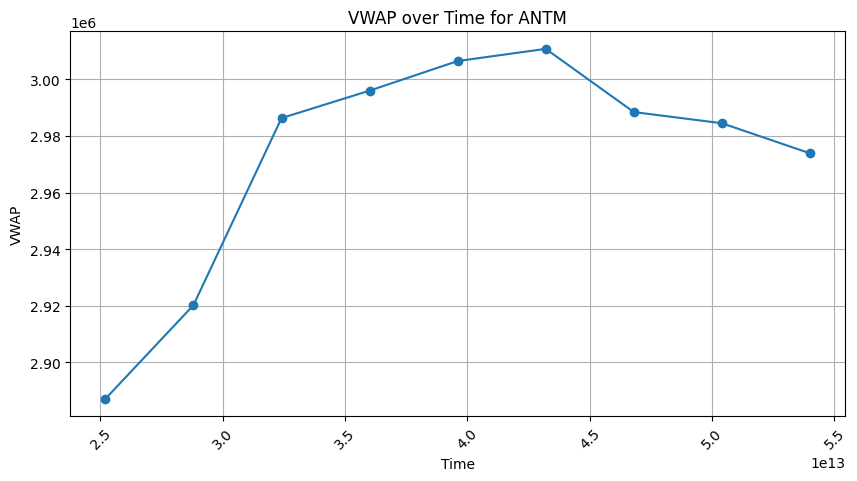

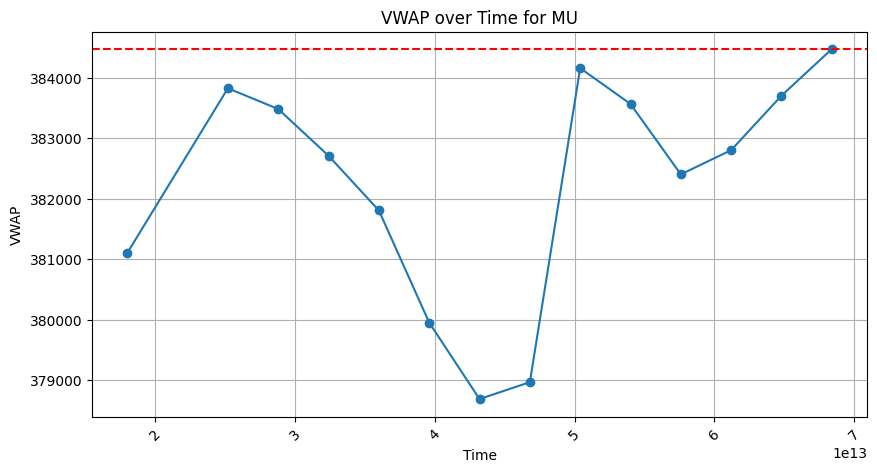

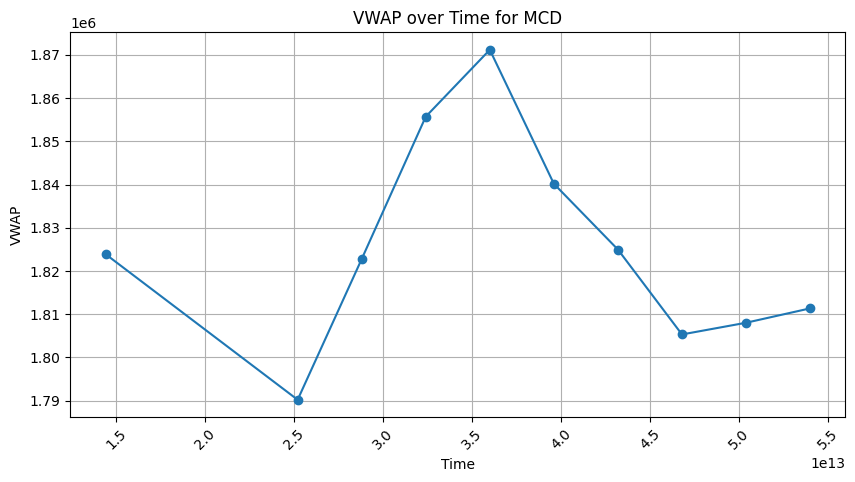

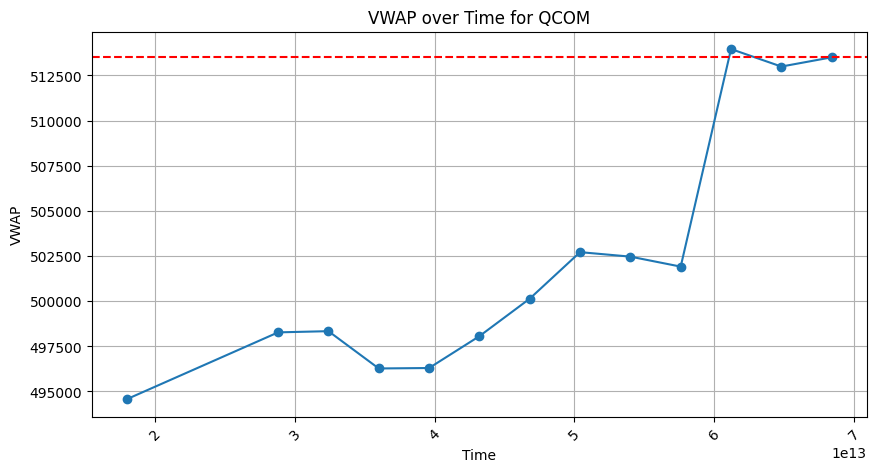

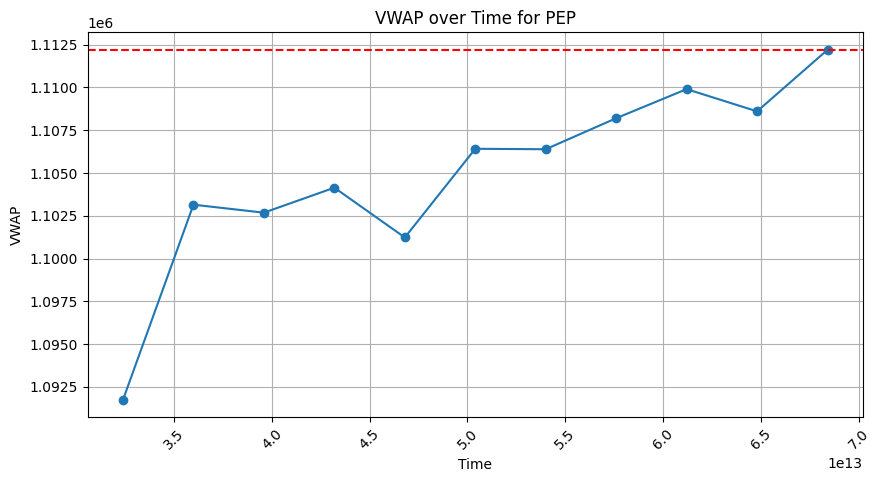

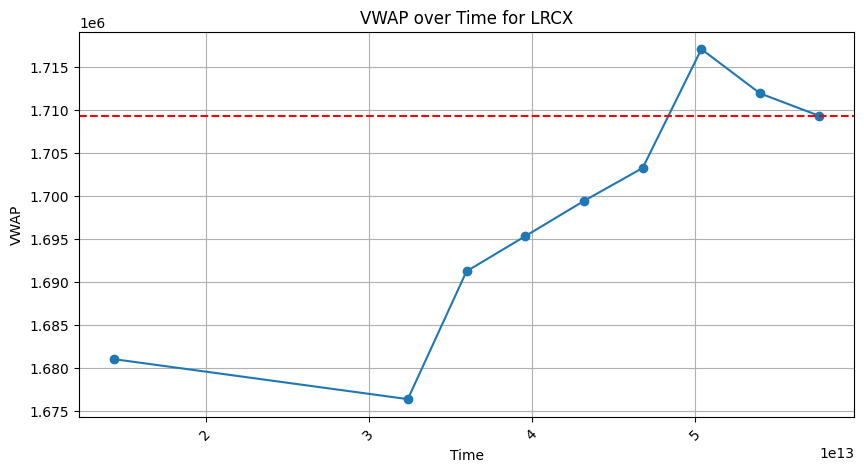

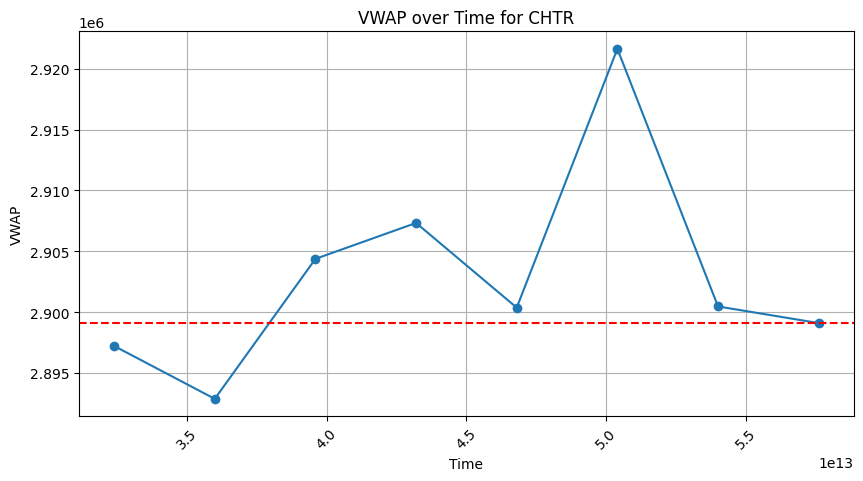

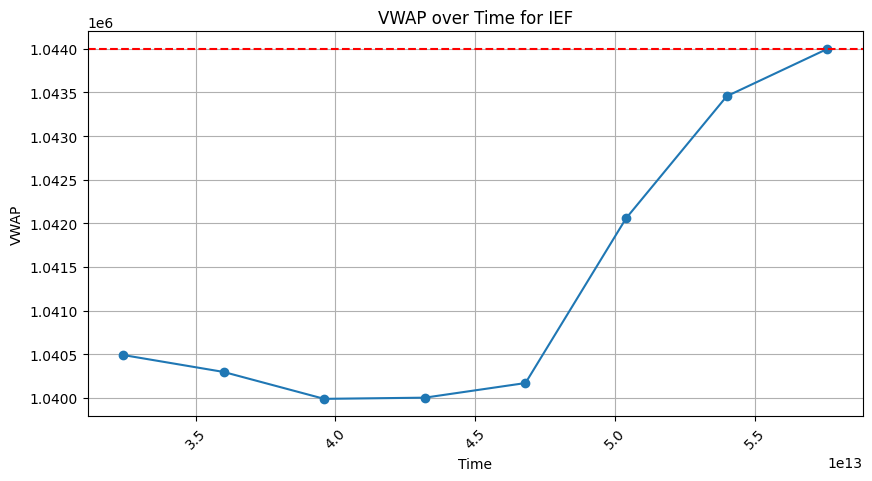

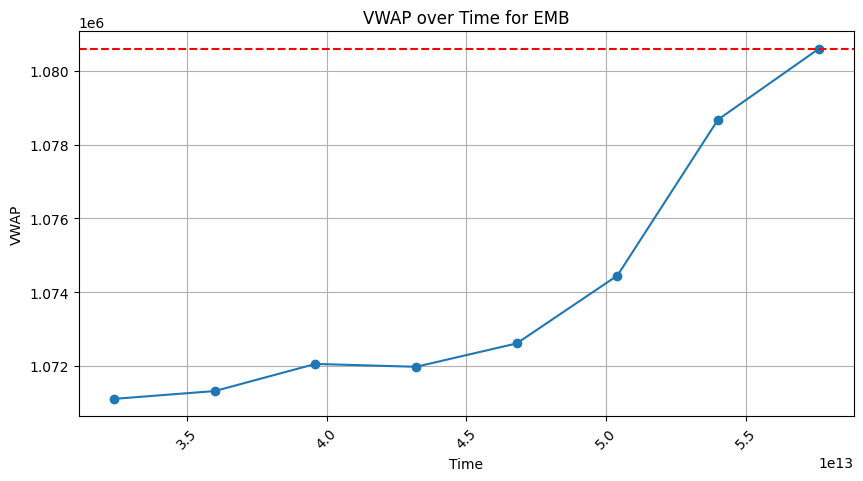

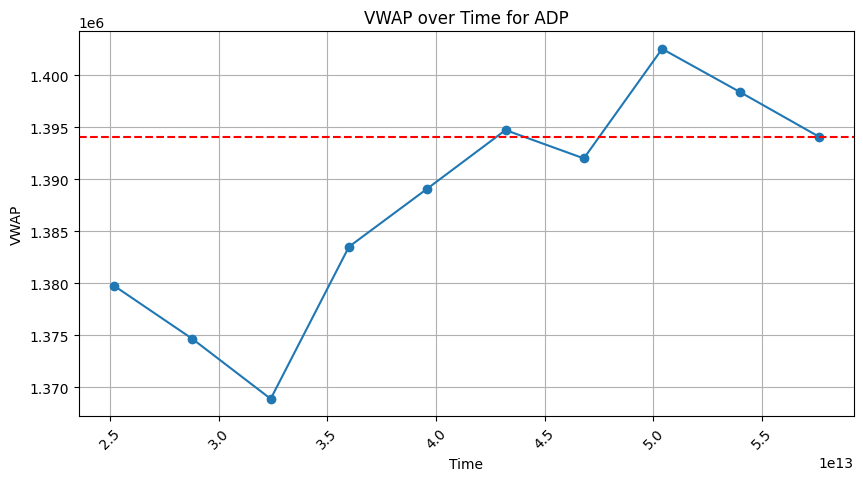

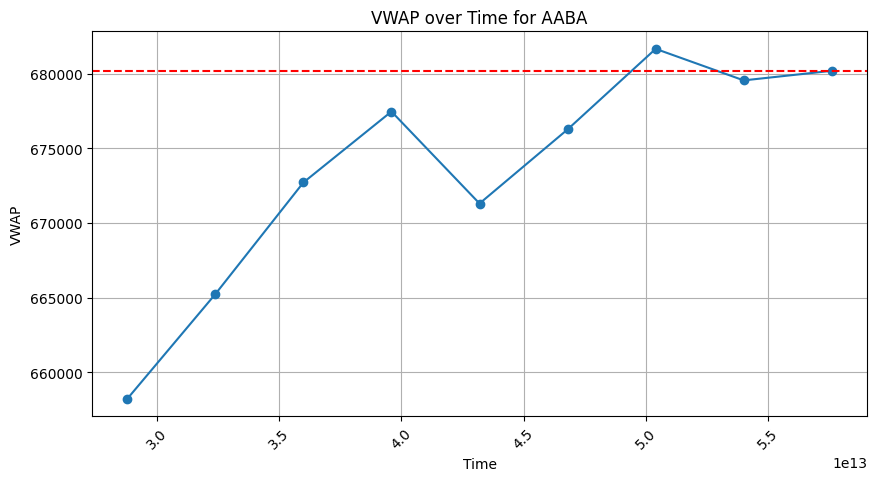

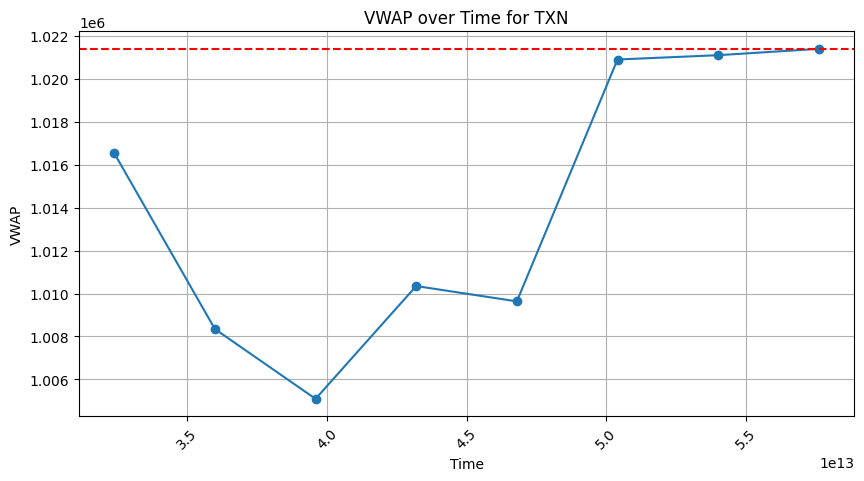

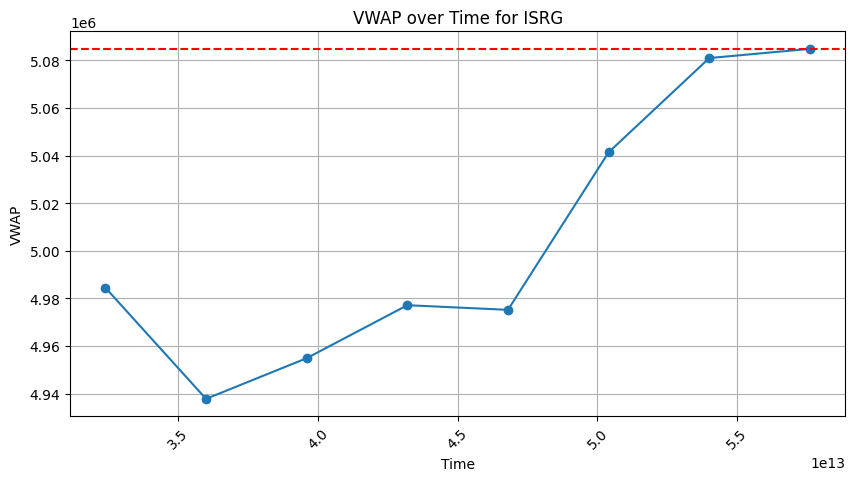

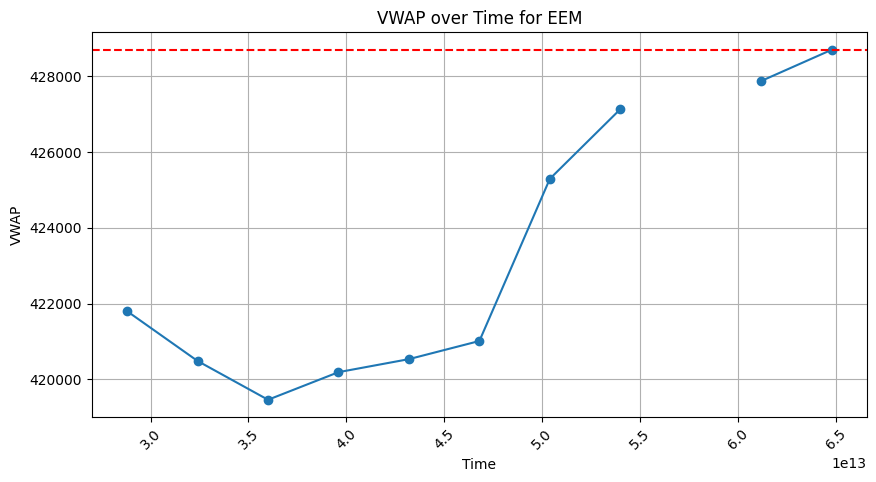

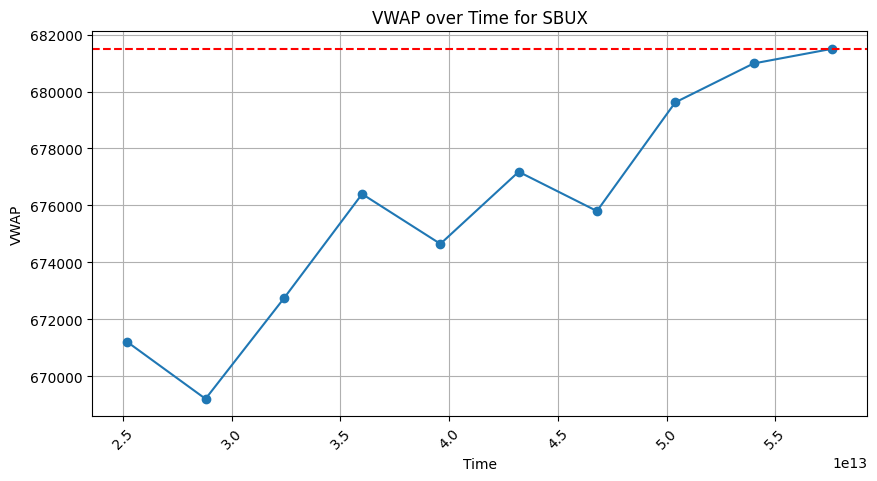

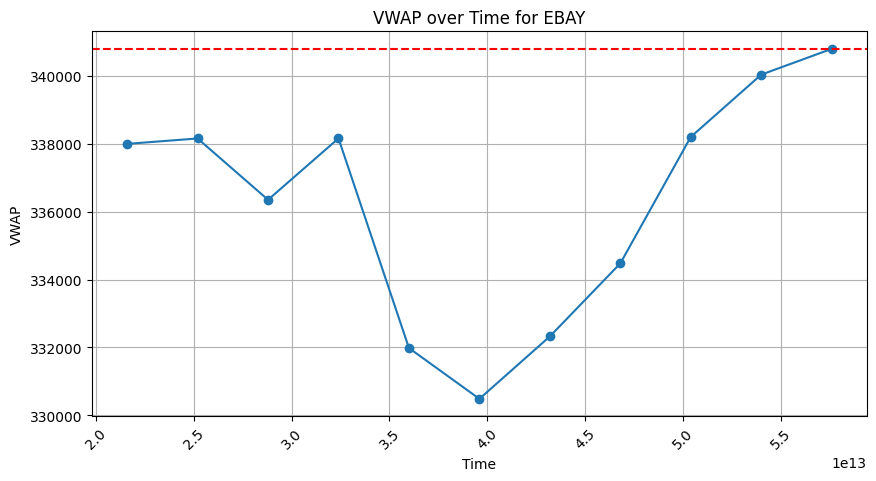

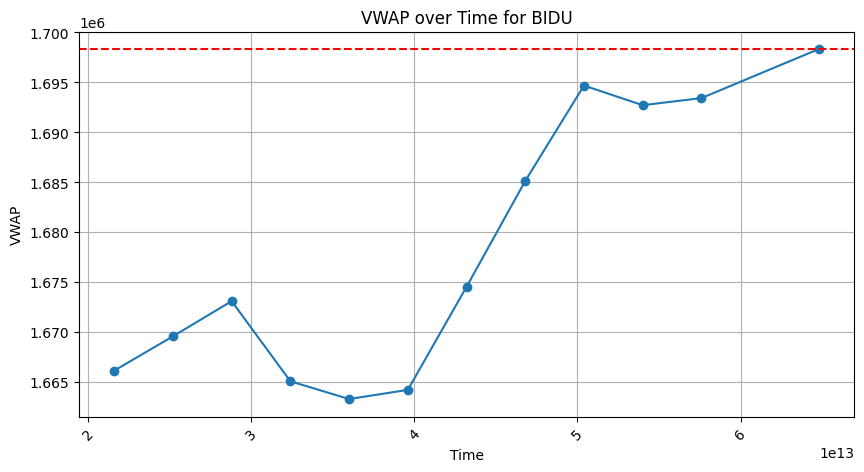

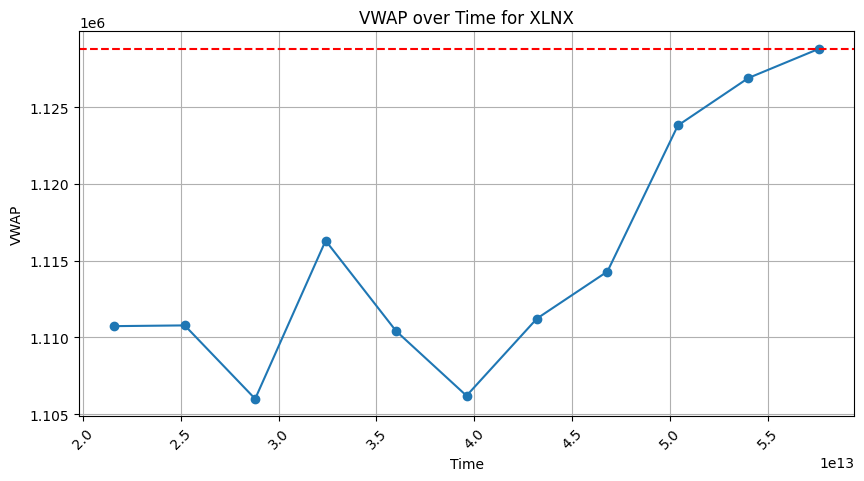

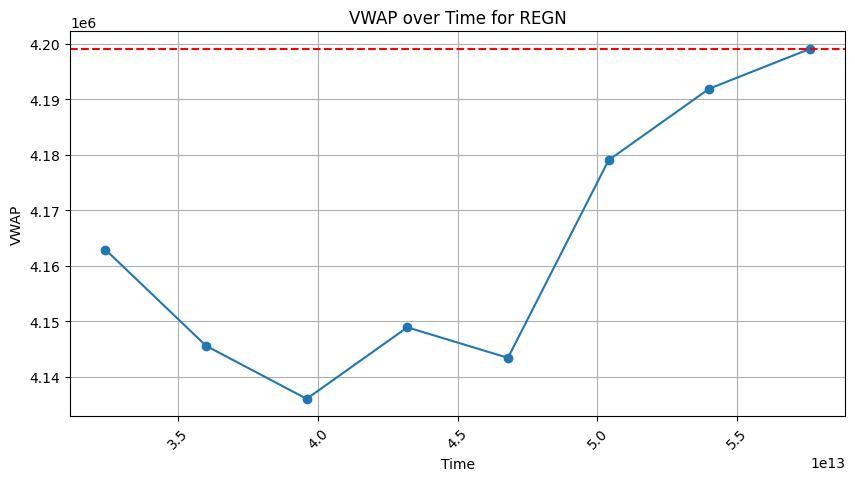

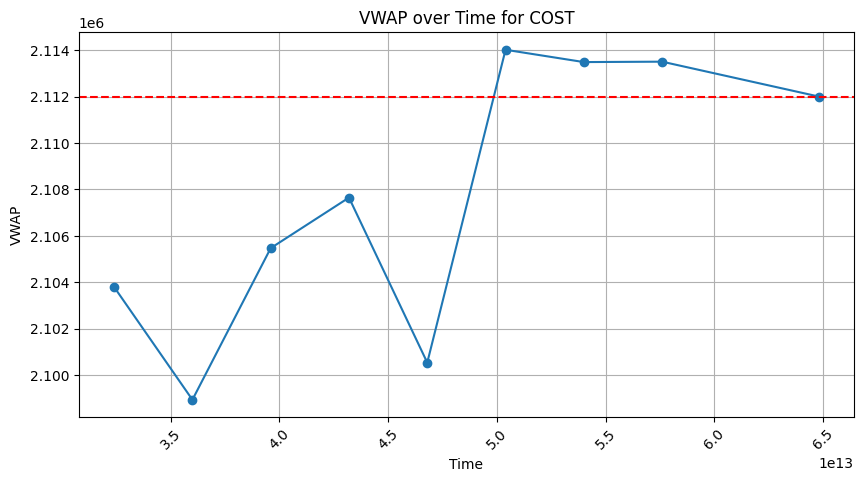

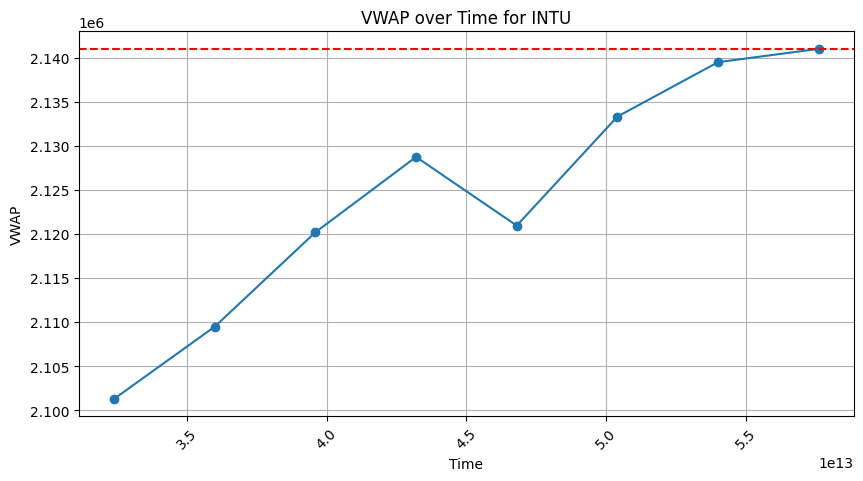

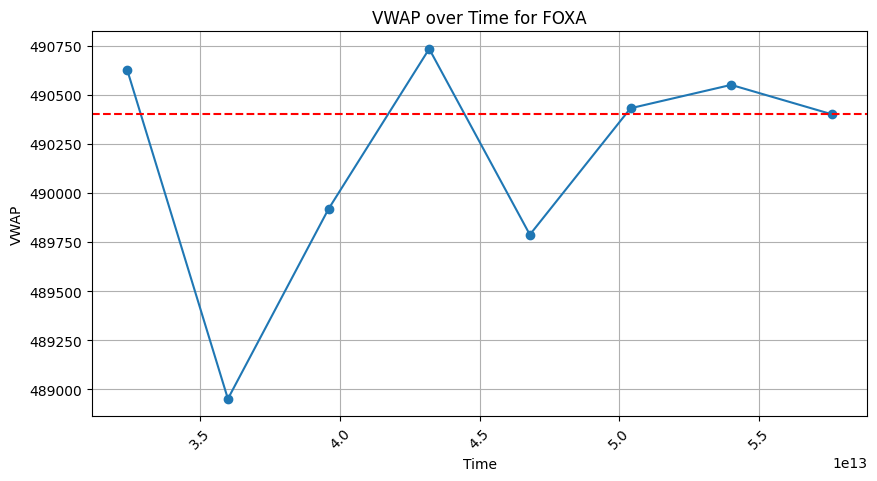

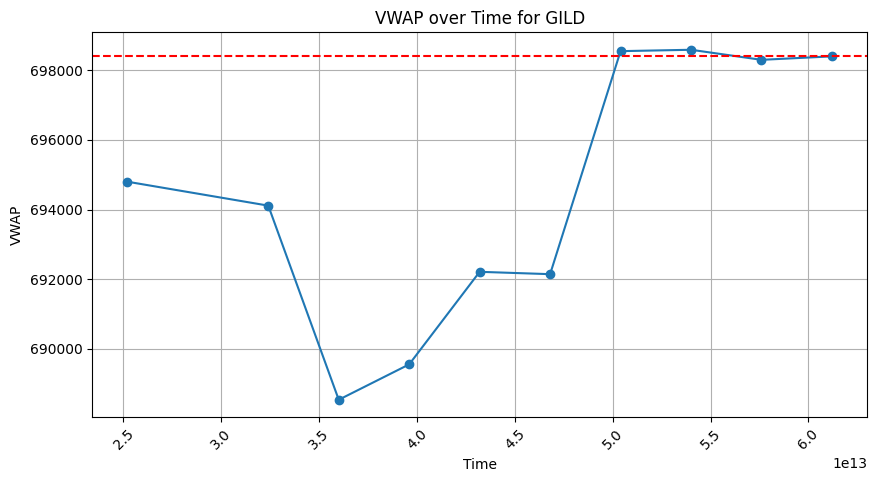

In [22]:
stocks = trades['stock'].unique()

for stock in top_10_stocks:

    df = vwap[vwap['stock']==stock]
    # Set 'timestamp' as the index for plotting
    # Plotting the VWAP for the stock
    plt.figure(figsize=(10, 5))
    df['VWAP'] = df['VWAP'].astype(float)
    closing_price = df.iloc[-1]['VWAP']  # Get the last VWAP value
    opening_price = df.iloc[0]['VWAP']
    #closing_time = df.iloc[-1]['timestamp']  # Get the last timestamp

    #print(closing_time.total_seconds())
    plt.plot(df['timestamp'], df['VWAP'], marker='o', label=stock)  # marker='o' adds a dot for each data point

    # # Annotate the closing VWAP price on the plot
    plt.axhline(y=closing_price, color='r', linestyle='--', label='Closing Price')

    plt.title(f'VWAP over Time for {stock}')
    plt.xlabel('Time')
    plt.ylabel('VWAP')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

    # Show the plot
    plt.show()

# **Opening and closing Prices for the top 50 stocks**

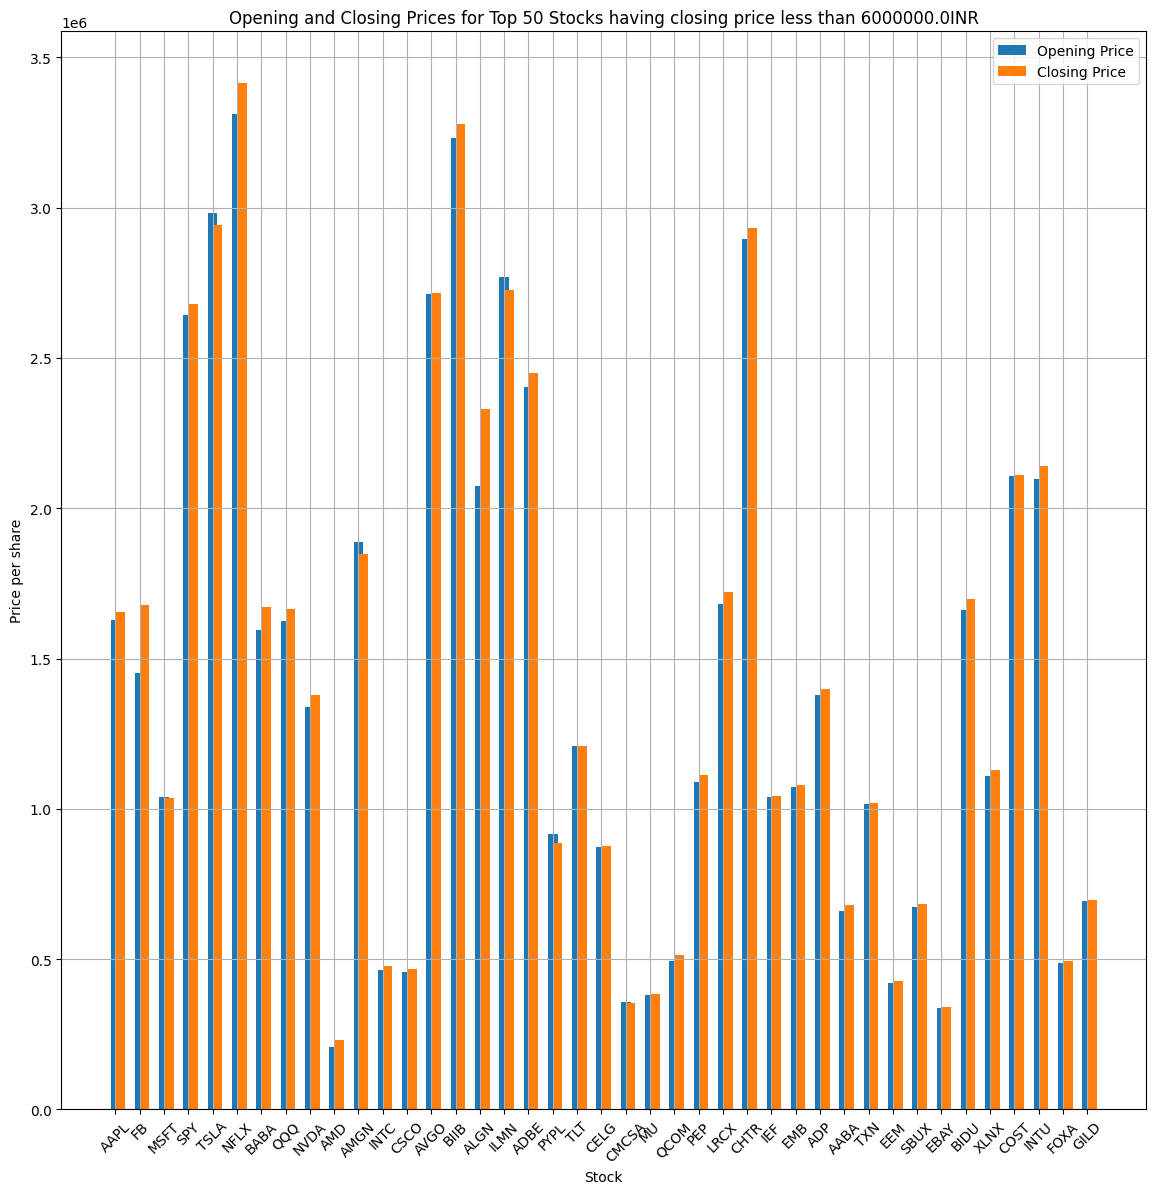

In [23]:

import matplotlib.pyplot as plt
import pandas as pd

# Initialize empty lists to hold the opening and closing prices
opening_prices = []
closing_prices = []
stcks=[]
threshold = 0.6e7
# Collect opening and closing prices for each stock
for stock in top_10_stocks:
    df = trades[trades['stock'] == stock]
    #df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')  # Ensure the data is ordered by time
    df['price'] = df['price'].astype(float)

    # Get the last VWAP value (closing price) and the first (opening price)
    closing_price = df.iloc[-1]['price']
    opening_price = df.iloc[0]['price']
    if(closing_price<4e6 and closing_price!=0):
      closing_prices.append(df.iloc[-1]['price'])
      opening_prices.append(df.iloc[0]['price'])
      stcks.append(stock)

# Now, create a bar plot with the opening and closing prices for each stock
fig, ax = plt.subplots(figsize=(14, 14))

# Create an index for each tick position
ind = range(len(stcks)) # range(len(top_10_stocks))

# Plot the opening prices
ax.bar(ind, opening_prices, width=0.4, label='Opening Price', align='center')

# Plot the closing prices
ax.bar(ind, closing_prices, width=0.4, label='Closing Price', align='edge')

# Set the title and labels
ax.set_title(f'Opening and Closing Prices for Top 50 Stocks having closing price less than {threshold}INR')
ax.set_xlabel('Stock')
ax.set_ylabel('Price per share')

# Set the x-ticks to the name of the stocks
ax.set_xticks(ind)
ax.set_xticklabels(stcks, rotation=45)

# Adding a legend and a grid
ax.legend()
ax.grid(True)

# Show the plot
plt.show()